The goal of this notebook is to predict whether a patient will be diagnosed with diabetes based on multiple factors :
* Alcohol consumption, screen time, BMI...
* Family history, gender, ethnicity ...

The submissions for this competition are evaluated using the area under the ROC curve:

<p style="text-align: center;">
  <img src="https://media.geeksforgeeks.org/wp-content/uploads/20230410164437/AUC-ROC-Curve.webp" alt="AUC-ROC Curve" width="500"/>
</p>


# 1. Importing Necessary Libraries

In [84]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("colorblind")

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier


from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, classification_report



RAND_STATE=42

# 2. Loading Data

In [56]:
train_df=pd.read_csv("/kaggle/input/playground-series-s5e12/train.csv")
test_df=pd.read_csv("/kaggle/input/playground-series-s5e12/test.csv")
ss_df=pd.read_csv("/kaggle/input/playground-series-s5e12/sample_submission.csv")

In [93]:
print("Training dataset shape :",train_df.shape)
print("Testing dataset shape :",test_df.shape)
print("Submission dataset shape :",ss_df.shape)

Training dataset shape : (700000, 25)
Testing dataset shape : (300000, 25)
Submission dataset shape : (300000, 2)


In [57]:
train_df.head()

,id,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,...,gender,ethnicity,education_level,income_level,smoking_status,employment_status,family_history_diabetes,hypertension_history,cardiovascular_history,diagnosed_diabetes
0,0,31,1,45,7.7,6.8,6.1,33.4,0.93,112,...,Female,Hispanic,Highschool,Lower-Middle,Current,Employed,0,0,0,1.0
1,1,50,2,73,5.7,6.5,5.8,23.8,0.83,120,...,Female,White,Highschool,Upper-Middle,Never,Employed,0,0,0,1.0
2,2,32,3,158,8.5,7.4,9.1,24.1,0.83,95,...,Male,Hispanic,Highschool,Lower-Middle,Never,Retired,0,0,0,0.0
3,3,54,3,77,4.6,7.0,9.2,26.6,0.83,121,...,Female,White,Highschool,Lower-Middle,Current,Employed,0,1,0,1.0
4,4,54,1,55,5.7,6.2,5.1,28.8,0.90,108,...,Male,White,Highschool,Upper-Middle,Never,Retired,0,1,0,1.0


In [58]:
test_df.head()

,id,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,...,triglycerides,gender,ethnicity,education_level,income_level,smoking_status,employment_status,family_history_diabetes,hypertension_history,cardiovascular_history
0,700000,45,4,100,4.3,6.8,6.2,25.5,0.84,123,...,111,Female,White,Highschool,Middle,Former,Employed,0,0,0
1,700001,35,1,87,3.5,4.6,9.0,28.6,0.88,120,...,145,Female,White,Highschool,Middle,Never,Unemployed,0,0,0
2,700002,45,1,61,7.6,6.8,7.0,28.5,0.94,112,...,184,Male,White,Highschool,Low,Never,Employed,0,0,0
3,700003,55,2,81,7.3,7.3,5.0,26.9,0.91,114,...,128,Male,White,Graduate,Middle,Former,Employed,0,0,0
4,700004,77,2,29,7.3,7.6,8.5,22.0,0.83,131,...,133,Male,White,Graduate,Low,Current,Unemployed,0,0,0


In [59]:
ss_df.head()

,id,diagnosed_diabetes
0,700000,0
1,700001,0
2,700002,0
3,700003,0
4,700004,0


# 3. Data Overview

In [60]:
#Show informations about the training dataset
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700000 entries, 0 to 699999
Data columns (total 26 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   id                                  700000 non-null  int64  
 1   age                                 700000 non-null  int64  
 2   alcohol_consumption_per_week        700000 non-null  int64  
 3   physical_activity_minutes_per_week  700000 non-null  int64  
 4   diet_score                          700000 non-null  float64
 5   sleep_hours_per_day                 700000 non-null  float64
 6   screen_time_hours_per_day           700000 non-null  float64
 7   bmi                                 700000 non-null  float64
 8   waist_to_hip_ratio                  700000 non-null  float64
 9   systolic_bp                         700000 non-null  int64  
 10  diastolic_bp                        700000 non-null  int64  
 11  heart_rate                

In [61]:
#Show informations about the testing dataset
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 25 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   id                                  300000 non-null  int64  
 1   age                                 300000 non-null  int64  
 2   alcohol_consumption_per_week        300000 non-null  int64  
 3   physical_activity_minutes_per_week  300000 non-null  int64  
 4   diet_score                          300000 non-null  float64
 5   sleep_hours_per_day                 300000 non-null  float64
 6   screen_time_hours_per_day           300000 non-null  float64
 7   bmi                                 300000 non-null  float64
 8   waist_to_hip_ratio                  300000 non-null  float64
 9   systolic_bp                         300000 non-null  int64  
 10  diastolic_bp                        300000 non-null  int64  
 11  heart_rate                

# 4. Checking Data Quality

In [62]:
train_df.drop(columns=['id'], inplace=True)

In [63]:
num_cols=train_df.select_dtypes(include=["number"]).columns.to_list()
print(num_cols)

['age', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week', 'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day', 'bmi', 'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate', 'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides', 'family_history_diabetes', 'hypertension_history', 'cardiovascular_history', 'diagnosed_diabetes']


In [64]:
cat_cols=train_df.select_dtypes(exclude=["number"]).columns.to_list()
print(cat_cols)

['gender', 'ethnicity', 'education_level', 'income_level', 'smoking_status', 'employment_status']


# 5. Exploratory Data Analysis

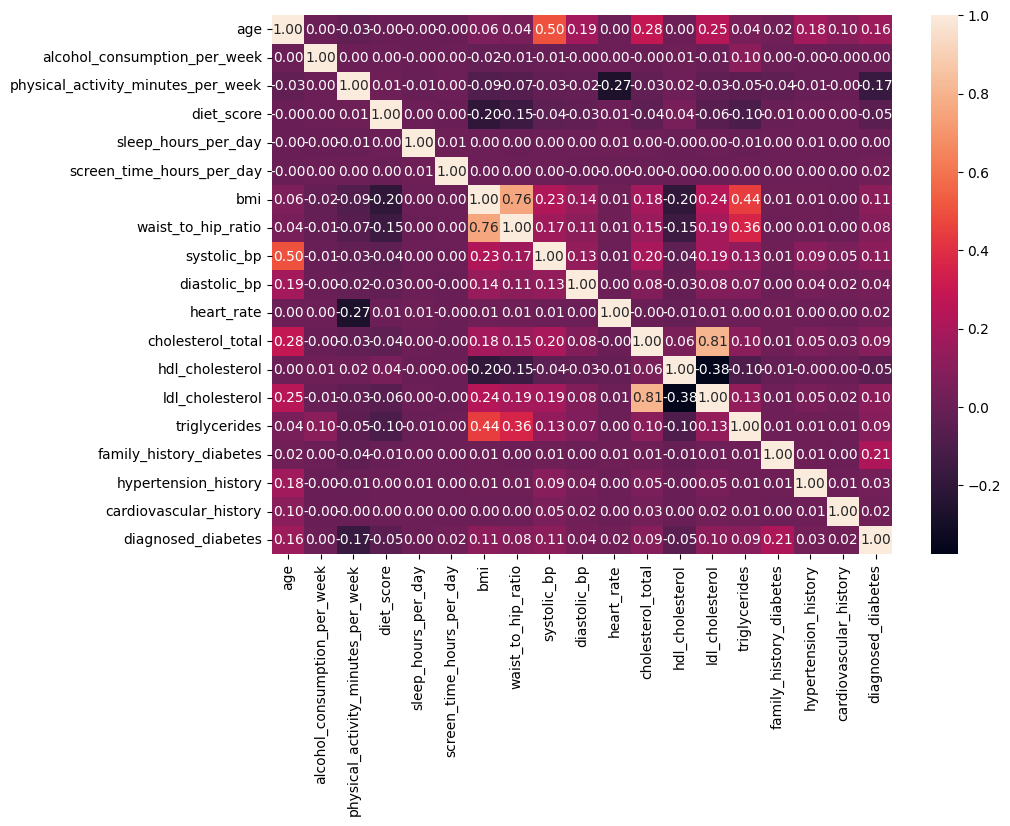

In [65]:
plt.figure(figsize=(10,7))
sns.heatmap(train_df[num_cols].corr(), annot=True, fmt=".2f")
plt.show()

# 6. Data Preprocessing

In [66]:
le=LabelEncoder()
for col in cat_cols:   
    train_df[col]=le.fit_transform(train_df[col])
    test_df[col]=le.transform(test_df[col])

In [67]:
scaler=StandardScaler()
train_df[num_cols[0:18]]=scaler.fit_transform(train_df[num_cols[0:18]])
test_df[num_cols[0:18]]=scaler.transform(test_df[num_cols[0:18]])

In [68]:
X=train_df.drop(columns=["diagnosed_diabetes"])
y=train_df["diagnosed_diabetes"]

In [72]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=RAND_STATE)

# 7. Modeling

In [73]:
logreg=LogisticRegression()
logreg.fit(X_train, y_train)
y_probs = logreg.predict_proba(X_test)[:, 1]
logreg_auc_score = round(roc_auc_score(y_test, y_probs),3)

In [75]:
print("AUC ROC for logistic regression model:",logreg_auc_score)

AUC ROC for logistic regression model: 0.694


In [78]:
catboost=CatBoostClassifier()
catboost.fit(X_train, y_train)
y_probs = catboost.predict_proba(X_test)[:, 1]
catboost_auc_score = round(roc_auc_score(y_test, y_probs),3)

Learning rate set to 0.153607
0:	learn: 0.6676203	total: 130ms	remaining: 2m 10s
1:	learn: 0.6495067	total: 197ms	remaining: 1m 38s
2:	learn: 0.6373453	total: 266ms	remaining: 1m 28s
3:	learn: 0.6287230	total: 335ms	remaining: 1m 23s
4:	learn: 0.6223033	total: 400ms	remaining: 1m 19s
5:	learn: 0.6174719	total: 466ms	remaining: 1m 17s
6:	learn: 0.6138528	total: 527ms	remaining: 1m 14s
7:	learn: 0.6112303	total: 595ms	remaining: 1m 13s
8:	learn: 0.6092872	total: 662ms	remaining: 1m 12s
9:	learn: 0.6075963	total: 724ms	remaining: 1m 11s
10:	learn: 0.6062466	total: 789ms	remaining: 1m 10s
11:	learn: 0.6052849	total: 854ms	remaining: 1m 10s
12:	learn: 0.6044983	total: 920ms	remaining: 1m 9s
13:	learn: 0.6036827	total: 988ms	remaining: 1m 9s
14:	learn: 0.6029806	total: 1.05s	remaining: 1m 8s
15:	learn: 0.6024439	total: 1.11s	remaining: 1m 8s
16:	learn: 0.6019399	total: 1.18s	remaining: 1m 8s
17:	learn: 0.6015579	total: 1.24s	remaining: 1m 7s
18:	learn: 0.6011748	total: 1.31s	remaining: 1m 7s

In [79]:
print("AUC ROC for catboost model:",catboost_auc_score)

AUC ROC for catboost model: 0.727


In [80]:
lgbm=LGBMClassifier()
lgbm.fit(X_train, y_train)
y_probs = lgbm.predict_proba(X_test)[:, 1]
lgbm_auc_score = round(roc_auc_score(y_test, y_probs),2)

[LightGBM] [Info] Number of positive: 348936, number of negative: 211064
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042798 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1643
[LightGBM] [Info] Number of data points in the train set: 560000, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.623100 -> initscore=0.502727
[LightGBM] [Info] Start training from score 0.502727


In [81]:
print("AUC ROC for lightGBM classifier model:",lgbm_auc_score)

AUC ROC for lightGBM classifier model: 0.72


In [82]:
xgb=XGBClassifier()
xgb.fit(X_train, y_train)
y_probs = xgb.predict_proba(X_test)[:, 1]
xgb_auc_score = round(roc_auc_score(y_test, y_probs),3)

In [83]:
print("AUC ROC for XGBoost classifier model:",xgb_auc_score)

AUC ROC for XGBoost classifier model: 0.723


In [85]:
rfc=RandomForestClassifier()
rfc.fit(X_train, y_train)
y_probs = rfc.predict_proba(X_test)[:, 1]
rfc_auc_score = round(roc_auc_score(y_test, y_probs),3)

In [86]:
print("AUC ROC for random forest model:",rfc_auc_score)

AUC ROC for random forest model: 0.693


In [87]:
ensemble=StackingClassifier(
    estimators=[("catboost",catboost),
                ("lgbm",lgbm),
                ("xgb",xgb),
                ("rfc",rfc)],
    final_estimator=LogisticRegression(),
    stack_method="predict_proba",
    cv=5)

In [88]:
ensemble.fit(X_train, y_train)

Learning rate set to 0.153607
0:	learn: 0.6676203	total: 86.1ms	remaining: 1m 26s
1:	learn: 0.6495067	total: 155ms	remaining: 1m 17s
2:	learn: 0.6373453	total: 224ms	remaining: 1m 14s
3:	learn: 0.6287230	total: 292ms	remaining: 1m 12s
4:	learn: 0.6223033	total: 356ms	remaining: 1m 10s
5:	learn: 0.6174719	total: 423ms	remaining: 1m 10s
6:	learn: 0.6138528	total: 485ms	remaining: 1m 8s
7:	learn: 0.6112303	total: 554ms	remaining: 1m 8s
8:	learn: 0.6092872	total: 621ms	remaining: 1m 8s
9:	learn: 0.6075963	total: 683ms	remaining: 1m 7s
10:	learn: 0.6062466	total: 747ms	remaining: 1m 7s
11:	learn: 0.6052849	total: 815ms	remaining: 1m 7s
12:	learn: 0.6044983	total: 879ms	remaining: 1m 6s
13:	learn: 0.6036827	total: 947ms	remaining: 1m 6s
14:	learn: 0.6029806	total: 1.01s	remaining: 1m 6s
15:	learn: 0.6024439	total: 1.07s	remaining: 1m 6s
16:	learn: 0.6019399	total: 1.14s	remaining: 1m 5s
17:	learn: 0.6015579	total: 1.21s	remaining: 1m 5s
18:	learn: 0.6011748	total: 1.27s	remaining: 1m 5s
19:	

StackingClassifier(cv=5,
                   estimators=[('catboost',
                                <catboost.core.CatBoostClassifier object at 0x7932951d59d0>),
                               ('lgbm', LGBMClassifier()),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              featu...
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...)),
                               ('rfc', RandomForestClassifier())],
                   final_estimator=LogisticRegression(),
                   stack_method='predict_proba')

In [89]:
y_pred = ensemble.predict(X_test)
print(f"VotingClassifier Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"ROC AUC Score: {round(roc_auc_score(y_test, y_pred),3)}")
print(f"Classification Report: \n{classification_report(y_test, y_pred)}")

VotingClassifier Accuracy: 0.685
ROC AUC Score: 0.634
Classification Report: 
              precision    recall  f1-score   support

         0.0       0.62      0.43      0.51     52629
         1.0       0.71      0.84      0.77     87371

    accuracy                           0.68    140000
   macro avg       0.66      0.63      0.64    140000
weighted avg       0.67      0.68      0.67    140000



In [90]:
models = ["logreg","catboost","lgbm","xgb","rfc","stacked_models"]
auc_roc= [logreg_auc_score, catboost_auc_score, lgbm_auc_score, xgb_auc_score, rfc_auc_score, round(roc_auc_score(y_test, y_pred),3)]

In [104]:
model_auc_roc = pd.DataFrame({"Model": models, "AUC_ROC": auc_roc})
model_auc_roc.sort_values("AUC_ROC",ignore_index=True)

,Model,AUC_ROC
0,stacked_models,0.634
1,rfc,0.693
2,logreg,0.694
3,lgbm,0.720
4,xgb,0.723
5,catboost,0.727


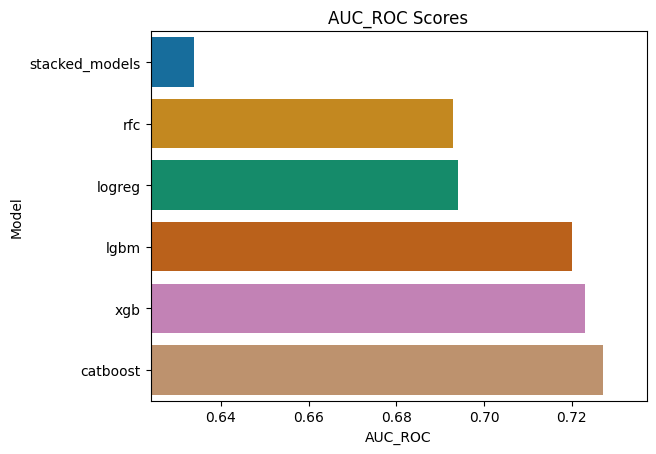

In [92]:
sns.barplot(x="AUC_ROC",y="Model",data=model_auc_roc.sort_values(by="AUC_ROC"))
plt.xlim(min(auc_roc)-0.01, max(auc_roc)+0.01) 
plt.ylabel("Model")
plt.title("AUC_ROC Scores")
plt.show()

# 8. Hyperparameters Tuning & Optimisation

In [109]:
param_grid = [
    {'penalty':['l1','l2','none'],
    'C' : np.logspace(-4,4,20),
    'solver': ['lbfgs','liblinear','sag'],
    'max_iter'  : [100,1000,2500,5000]
}
]

In [110]:
from sklearn.model_selection import GridSearchCV
clf = GridSearchCV(logreg,param_grid = param_grid, cv = 3, verbose=True,n_jobs=-1)
clf

GridSearchCV(cv=3, estimator=LogisticRegression(), n_jobs=-1,
             param_grid=[{'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                          'max_iter': [100, 1000, 2500, 5000],
                          'penalty': ['l1', 'l2', 'none'],
                          'solver': ['lbfgs', 'liblinear', 'sag']}],
             verbose=True)

In [111]:
best_clf = clf.fit(X_train, y_train)
best_clf.best_estimator_

Fitting 3 folds for each of 720 candidates, totalling 2160 fits


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour

LogisticRegression(C=11.288378916846883, max_iter=1000, solver='sag')

In [113]:
y_pred = best_clf.predict(X_test)
round(roc_auc_score(y_test, y_pred),3)

0.595